In [12]:
%run ./header.ipynb
print(dir_string)

vol_high_z


In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [15]:
np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()

True

In [16]:
UPPER_BOUND=np.max(1.5*clusters[('All','All','R_LAMBDA')])

In [17]:
def get_ng(cluster,mode):
    
    if mode == "s":
        def get_cluster_cen(cluster):
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            return (shapes.loc[cen_id])
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            return (sats)
    elif mode=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)
        
    else:
        raise
        
    
    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)
    
    
    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[('All','angR')]
    
#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
#         cen_e1=np.array(cen[('All','e1')]).reshape(1)
#         cen_e2=np.array(cen[('All','e2')]).reshape(1)
        cen_angr=np.array(cen[('All','angR')]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[('All','angR')].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()
        
    

    
#     print(cen_e1,cen_e2)
    
    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()
    

    
    
#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    
        
    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')
    ## divide by R200m
    
    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')
    
    ng = treecorr.NGCorrelation(nbins=20, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,bin_type="Linear",
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)
    
    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster):
    ng=get_ng(cluster,'s')
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
def get_r_xi_meanlogr_varxi_npairs(cluster):
    ng=get_ng(cluster,'r')
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [20]:
length=len(clusters)
ng_list=np.empty([length,4,20])

i=0
for index,cluster in tqdm(clusters.iterrows()):
    ng_list[(i),:,:]=get_xi_meanlogr_varxi_npairs(cluster)
    i=i+1
np.save("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string),ng_list)

print("File saved!")

11944it [00:33, 353.18it/s]

File saved!


In [21]:
ng_r=get_r_xi_meanlogr_varxi_npairs(cluster.iloc[1])
np.save("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string),ng_r)
print("File saved!")

File saved!


In [22]:
ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))
length=len(clusters)

In [23]:
ng_xi_array=np.empty([length,20])
ng_meanlogr_array=np.empty([length,20])
ng_varxi_array=np.empty([length,20])
ng_npairs_array=np.empty([length,20])
for i in range(length):
    ng_xi_array[i,:]=ng_list[i,0,:]
    ng_meanlogr_array[i,:]=ng_list[i,1,:]
    ng_varxi_array[i,:]=ng_list[i,2,:]
    ng_npairs_array[i,:]=ng_list[i,3,:]
final_xi_cross_array=np.sum(ng_xi_array,axis=0)
final_npairs_array=np.sum(ng_npairs_array,axis=0)
final_xi_array=final_xi_cross_array/final_npairs_array

final_r_xi=ng_r[0]/ng_r[3]

final_r_sigma=final_r_xi/np.sqrt(length)

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [24]:
final_xi=final_xi_array-final_r_xi
final_meanlogr=np.sum(ng_meanlogr_array,axis=0)/np.sum(ng_npairs_array,axis=0)
final_sigma=np.mean(np.sqrt(ng_varxi_array),axis=0)/np.sqrt(length)

final_sigma=(final_xi_array-final_r_xi)/np.sqrt(length)

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [31]:
def get_sigma(ng_xi_array,ng_npairs_array):
    
    N=len(ng_xi_array)
    
    jk_xi_array=np.empty([N,20])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(ng_xi_array,i,axis=0)
        drop_1_npairs=np.delete(ng_npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

final_sigma=get_sigma(ng_xi_array,ng_npairs_array)

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [32]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
#     plt.xscale('log')
#     plt.yscale('log')

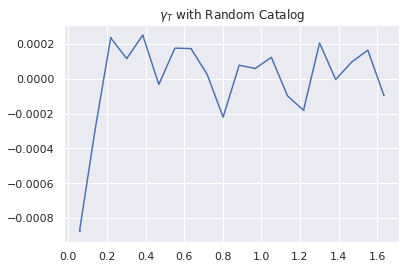

In [33]:
plt_w_error(ng_r[1]/ng_r[3],-final_r_xi,final_r_sigma,r"$\gamma_T$ with Random Catalog")

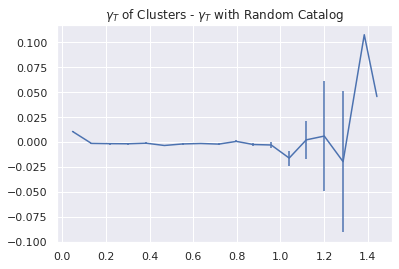

In [34]:
plt_w_error(final_meanlogr,-final_xi,final_sigma,r"$\gamma_T$ of Clusters - $\gamma_T$ with Random Catalog")

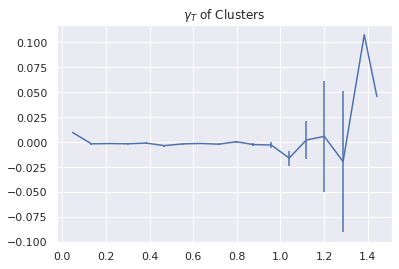

In [35]:
plt_w_error(final_meanlogr,-final_xi_array,final_sigma,r"$\gamma_T$ of Clusters ")

In [30]:
def get_rel_ng(cluster,mode):
    
    if mode == "s":
        def get_cluster_cen(cluster):
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            return (shapes.loc[cen_id])
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            return (sats)
    elif mode=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)
        
    else:
        raise
        

    

    

    
    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)
    
    
    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[('All','angR')]
    
#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
#         cen_e1=np.array(cen[('All','e1')]).reshape(1)
#         cen_e2=np.array(cen[('All','e2')]).reshape(1)
        cen_angr=np.array(cen[('All','angR')]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[('All','angR')].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()
        
    

    
#     print(cen_e1,cen_e2)
    
    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()
    

    
    
#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    
        
    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')
    
    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')
    
    ng = treecorr.NGCorrelation(nbins=20, min_sep=0.01, max_sep=1.8, bin_slop=0.0,bin_type="Linear",
                               metric="Rperp")
    ng.process(cen_cat,sats_cat)
    
    return(ng)

In [21]:
# def plt_gg(gg,title=None):
#     corrfunc=gg['gg']
#     length = gg['length']
#     g1avg = gg['g1avg']
#     g2avg = gg['g2avg']
#     g1sigma=gg['g1sigma']
#     g2sigma=gg['g2sigma']
    
# #     gg_dict={'gg':gg, 'length':len(catalog), 'g1avg':np.mean(catalog['delta_g1']), 'g2_avg':np.mean(catalog['delta_g1']),
# #                 'g1sigma':np.std(catalog['delta_g1']),'g2sigma':np.std(catalog['delta_g2'])} 
        
#     textstr = '\n'.join((
#         r'$n=%.2e$' % (length, ),
#         r'$g1_{avg}=%.2e$' % (g1avg, ),
#         r'$\sigma_{g1}=%.2e$' % (g1sigma, ),
#         r'$g2_{avg}=%.2e$' % (g2avg, ),
#         r'$\sigma_{g2}=%.2e$' % (g2sigma, )))
    
    
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#     fig,ax = plt.subplots()
#     ax.errorbar(np.exp(corrfunc.meanlogr),corrfunc.xip,yerr=np.sqrt(corrfunc.varxip))
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.title(title+'_xip')
#     plt.xlabel('$\\theta$/arcmin')
#     ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=5,
#             verticalalignment='top', bbox=props)
#     plt.savefig('/home/cz136/project/balrog/image/corr/{}_xip'.format(title),dpi=150)
#     plt.close()
    
#     fig,ax = plt.subplots()
#     plt.errorbar(corrfunc.meanlogr,corrfunc.xim,yerr=np.sqrt(corrfunc.varxim))
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.title(title+'_xim')
#     plt.xlabel(r"$\theta$ /arcmin")
#     ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=5,
#             verticalalignment='top', bbox=props)
#     plt.savefig('/home/cz136/project/balrog/image/corr/{}_xim'.format(title),dpi=150)
#     plt.close()